# Car Reservations:
---

In [1]:
import warnings
import itertools
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats
import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns
sns.set(color_codes = True)
cmap = lambda c: ListedColormap(sns.color_palette(c).as_hex())
import scikitplot.plotters as skplt
import statsmodels.discrete.discrete_model as sm
from sklearn import preprocessing, model_selection, feature_extraction, feature_selection, linear_model, svm, tree, ensemble, metrics
%matplotlib inline

## Load Data:
---

In [2]:
res = pd.read_csv('reservations.csv')
res.index += 1
res.index.name = 'res_id'
res.iloc[[0,1,-2,-1]]

,vehicle_id,reservation_type
res_id,,
1,208,1
2,601,3
6375,687,2
6376,687,2


In [3]:
vec = pd.read_csv('vehicles.csv')
vec.set_index('vehicle_id', inplace = True)
vec.iloc[[0,1,2,-3,-2,-1]]

,technology,actual_price,recommended_price,num_images,street_parked,description
vehicle_id,,,,,,
1,1,67.85,59,5,0,7
2,0,100.70,53,5,0,224
3,0,74.00,74,4,1,21
998,0,139.32,81,4,0,35
999,0,72.76,68,4,1,199
1000,0,76.44,42,4,1,92


## Merge Tweak Data:
---

In [4]:
# For a binary reserved/non-reserved classifier approach...
vres = vec.reset_index().merge(res, on = 'vehicle_id', how = 'left')
vres.reservation_type.fillna(0, inplace = True) # Add a non-reserved type.
vres.reservation_type = vres.reservation_type.astype(int)
vres.insert(0, 'reserved', (vres.reservation_type > 0).astype(int))
vres.insert(4, 'price_delta', vres.actual_price - vres.recommended_price)
vres.drop('recommended_price', axis = 1, inplace = True)
np.random.seed(0)
vres['rand'] = np.random.normal(0, 0.1, len(vres))**2
vres.index += 1
vres.index.name = 'rvid'
vres.iloc[[0,1,2,-3,-2,-1]]

,reserved,vehicle_id,technology,actual_price,price_delta,num_images,street_parked,description,reservation_type,rand
rvid,,,,,,,,,,
1,1,1,1,67.85,8.85,5,0,7,1,0.031119
2,1,2,0,100.70,47.70,5,0,224,1,0.001601
3,1,2,0,100.70,47.70,5,0,224,2,0.009579
6463,1,1000,0,76.44,34.44,4,1,92,2,0.033416
6464,1,1000,0,76.44,34.44,4,1,92,2,0.004569
6465,1,1000,0,76.44,34.44,4,1,92,3,0.001239


In [5]:
# For a days reserved regression approach...
rvec = vec.reset_index().merge(res, on = 'vehicle_id', how = 'left')
rvec.reservation_type.fillna(0, inplace = True) # Add a non-reserved type.
rvec.insert(1, 'rdays', rvec.reservation_type.astype(int))
rvec.insert(5, 'price_delta', rvec.actual_price - rvec.recommended_price)
rvec.drop(['recommended_price', 'reservation_type'], axis = 1, inplace = True)
rvec_cols = rvec.columns[1:].tolist()
grp_aggs = {'rdays': np.sum, 'technology': np.max, 'actual_price': np.mean, 'price_delta': np.mean,
            'num_images': np.max, 'street_parked': np.max, 'description': np.max}
rvec = rvec.groupby('vehicle_id').agg(grp_aggs)[rvec_cols]
np.random.seed(1)
rvec['rand'] = np.random.normal(0, 0.1, len(rvec))**2
rvec.iloc[[0,1,2,-3,-2,-1]]

,rdays,technology,actual_price,price_delta,num_images,street_parked,description,rand
vehicle_id,,,,,,,,
1,1,1,67.85,8.85,5,0,7,0.026385
2,10,0,100.70,47.70,5,0,224,0.003742
3,40,0,74.00,0.00,4,1,21,0.002790
998,10,0,139.32,58.32,4,0,35,0.000048
999,24,0,72.76,4.76,4,1,199,0.001252
1000,15,0,76.44,34.44,4,1,92,0.000350


## Initial Data Overview:
---

In [6]:
print('Top vehicles by reservation count:')
top_rentals = pd.DataFrame(res.vehicle_id.value_counts()[:10]).rename(columns = {'vehicle_id':'reservations'})
vec.loc[top_rentals.index].join(top_rentals)

Top vehicles by reservation count:


,technology,actual_price,recommended_price,num_images,street_parked,description,reservations
247,1,61.80,60,4,1,208,25
687,0,82.62,81,2,1,10,25
483,1,51.50,50,5,0,50,25
812,0,86.86,86,1,0,142,24
690,1,58.14,57,4,0,24,24
634,0,83.43,81,4,1,4,21
271,0,64.64,64,4,0,1,21
607,0,58.32,54,2,0,204,20
499,0,56.73,61,4,0,47,20
77,1,53.00,50,3,1,233,20


In [7]:
print('Top vehicles by reservation days:')
rvec.sort_values('rdays', ascending = False).head(10)

Top vehicles by reservation days:


,rdays,technology,actual_price,price_delta,num_images,street_parked,description,rand
vehicle_id,,,,,,,,
483,54,1,51.50,1.50,5,0,50,0.005888
812,47,0,86.86,0.86,1,0,142,0.011274
634,46,0,83.43,2.43,4,1,4,0.000523
687,45,0,82.62,1.62,2,1,10,0.002027
247,43,1,61.80,1.80,4,1,208,0.003826
499,43,0,56.73,-4.27,4,0,47,0.012270
427,43,0,62.40,2.40,3,1,195,0.002296
690,42,1,58.14,1.14,4,0,24,0.000197
343,41,0,70.00,0.00,5,1,183,0.001956


In [8]:
print('Watchout for skewvivor bias.')
pd.DataFrame(vres.reservation_type.value_counts()).style.background_gradient(cmap = 'GnBu')

Watchout for skewvivor bias.


,reservation_type
1,2339
2,2057
3,1980
0,89


In [9]:
vres.reserved.mean()

0.98623356535189477

### Sweet, we can construct a 98.6% accurate binary model for the data by predicting a positive reservation for any feature vector.

In [10]:
vres.head()

,reserved,vehicle_id,technology,actual_price,price_delta,num_images,street_parked,description,reservation_type,rand
rvid,,,,,,,,,,
1,1,1,1,67.85,8.85,5,0,7,1,0.031119
2,1,2,0,100.70,47.70,5,0,224,1,0.001601
3,1,2,0,100.70,47.70,5,0,224,2,0.009579
4,1,2,0,100.70,47.70,5,0,224,2,0.050216
5,1,2,0,100.70,47.70,5,0,224,1,0.034878


In [11]:
print('Binary correlation matrix, top row reordered by reservation correlation:')
feats = ['reserved','num_images','technology','description','street_parked','actual_price','price_delta','rand']
rcorrs = pd.DataFrame(vres[feats].corr('spearman').iloc[0].sort_values(ascending = False))
corrs = vres[feats][rcorrs.index].corr('spearman')
corrs.style.background_gradient(cmap = 'GnBu')

Binary correlation matrix, top row reordered by reservation correlation:


,reserved,num_images,technology,description,rand,street_parked,actual_price,price_delta
reserved,1,0.0638571,0.00839879,0.00835883,0.00483044,-0.0159243,-0.0340387,-0.0607055
num_images,0.0638571,1,-0.0298467,-0.0127105,0.00111793,0.0205964,0.0118842,0.0831256
technology,0.00839879,-0.0298467,1,0.0132455,-0.0103819,0.0113319,-0.518634,-0.380639
description,0.00835883,-0.0127105,0.0132455,1,-0.0138582,0.00906619,0.00314073,-0.0109326
rand,0.00483044,0.00111793,-0.0103819,-0.0138582,1,0.00542804,0.00486185,-0.00966923
street_parked,-0.0159243,0.0205964,0.0113319,0.00906619,0.00542804,1,-0.0145309,-0.0199393
actual_price,-0.0340387,0.0118842,-0.518634,0.00314073,0.00486185,-0.0145309,1,0.772868
price_delta,-0.0607055,0.0831256,-0.380639,-0.0109326,-0.00966923,-0.0199393,0.772868,1


In [12]:
print('Continuous correlation matrix, top row reordered by reservation correlation:')
vcorrs = pd.DataFrame(rvec.corr('spearman').iloc[0].sort_values(ascending = False))
corrs2 = rvec[vcorrs.index].corr('spearman')
corrs2.style.background_gradient(cmap = 'GnBu')

Continuous correlation matrix, top row reordered by reservation correlation:


,rdays,num_images,technology,description,street_parked,rand,actual_price,price_delta
rdays,1,0.244454,0.0498441,0.00593219,-0.0158922,-0.0273682,-0.195155,-0.320801
num_images,0.244454,1,-0.00425906,0.00518995,-0.00602211,0.0206277,-0.0645357,-0.0502798
technology,0.0498441,-0.00425906,1,0.0474768,-0.0046333,0.00894539,-0.510482,-0.366199
description,0.00593219,0.00518995,0.0474768,1,-0.0154195,0.0126109,-0.0082742,-0.0242628
street_parked,-0.0158922,-0.00602211,-0.0046333,-0.0154195,1,-0.0149027,0.00620571,-0.00580032
rand,-0.0273682,0.0206277,0.00894539,0.0126109,-0.0149027,1,0.0108539,0.0320478
actual_price,-0.195155,-0.0645357,-0.510482,-0.0082742,0.00620571,0.0108539,1,0.809718
price_delta,-0.320801,-0.0502798,-0.366199,-0.0242628,-0.00580032,0.0320478,0.809718,1


In [13]:
print('Eigenvector analysis of the correlation matrix:\n')
print('Eigenvalue \t\t\t\t Sorted Eigenvector Dimensions')
eig_vals, eig_vecs = np.linalg.eig(corrs2.as_matrix())
eig_vals_sorted = np.sort(eig_vals)[::-1]
eig_vecs_sorted = eig_vecs[:, eig_vals.argsort()][::-1]
for i in range(len(eig_vals)):
    print(eig_vals_sorted[i], [*corrs.columns[[x[0] for x in sorted([*enumerate(np.abs(eig_vecs_sorted[i]))], key = lambda x: -x[1])]]])

Eigenvector analysis of the correlation matrix:

Eigenvalue 				 Sorted Eigenvector Dimensions
2.25857150278 ['reserved', 'price_delta', 'num_images', 'technology', 'street_parked', 'actual_price', 'description', 'rand']
1.19498903782 ['reserved', 'price_delta', 'num_images', 'actual_price', 'description', 'rand', 'technology', 'street_parked']
1.03383174543 ['rand', 'street_parked', 'technology', 'description', 'price_delta', 'reserved', 'actual_price', 'num_images']
0.988751866591 ['description', 'street_parked', 'rand', 'actual_price', 'num_images', 'technology', 'reserved', 'price_delta']
0.984345624341 ['description', 'street_parked', 'rand', 'technology', 'num_images', 'actual_price', 'price_delta', 'reserved']
0.77493222295 ['num_images', 'technology', 'price_delta', 'actual_price', 'reserved', 'street_parked', 'rand', 'description']
0.60137485877 ['actual_price', 'technology', 'num_images', 'price_delta', 'rand', 'street_parked', 'description', 'reserved']
0.163203141315 ['actu

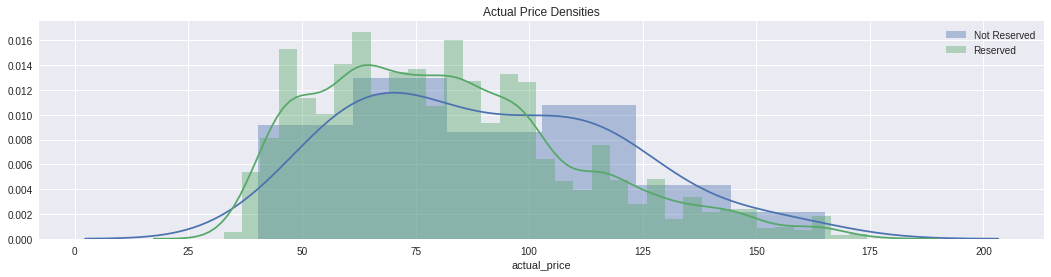

In [14]:
plt.figure(figsize = (18,4))
sns.distplot(vres[vres.reserved == 0].actual_price, label='Not Reserved')
sns.distplot(vres[vres.reserved == 1].actual_price, label = 'Reserved')
plt.title('Actual Price Densities')
plt.legend();

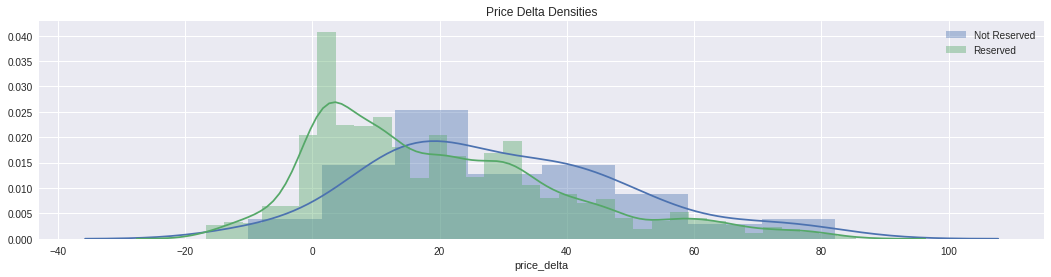

In [15]:
plt.figure(figsize = (18,4))
sns.distplot(vres[vres.reserved == 0].price_delta, label='Not Reserved')
sns.distplot(vres[vres.reserved == 1].price_delta, label = 'Reserved')
plt.title('Price Delta Densities')
plt.legend();

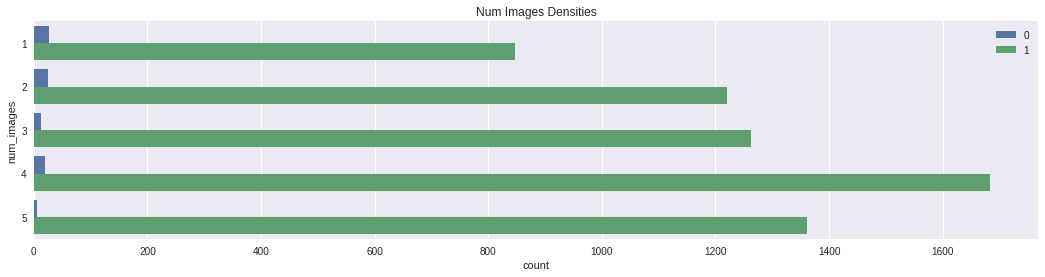

In [16]:
plt.figure(figsize = (18,4))
sns.countplot(y = 'num_images', hue = 'reserved', data = vres, orient = 'h')
plt.title('Num Images Densities')
plt.legend();

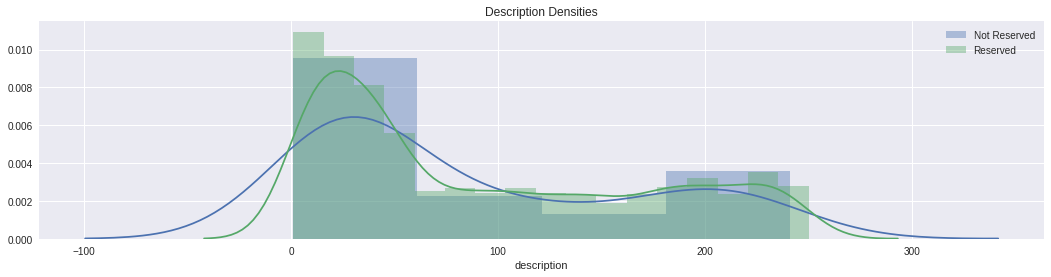

In [17]:
plt.figure(figsize = (18,4))
sns.distplot(vres[vres.reserved == 0].description, label='Not Reserved')
sns.distplot(vres[vres.reserved == 1].description, label = 'Reserved')
plt.title('Description Densities')
plt.legend();

In [18]:
vres.head(1)

,reserved,vehicle_id,technology,actual_price,price_delta,num_images,street_parked,description,reservation_type,rand
rvid,,,,,,,,,,
1,1,1,1,67.85,8.85,5,0,7,1,0.031119


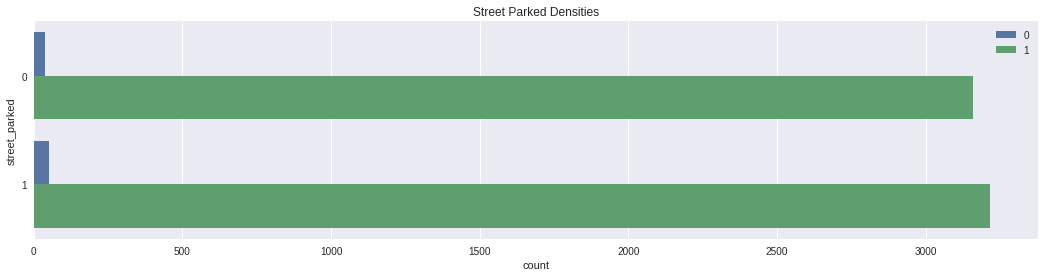

In [19]:
plt.figure(figsize = (18,4))
sns.countplot(y = 'street_parked', hue = 'reserved', data = vres, orient = 'h')
plt.title('Street Parked Densities')
plt.legend();

## The impact of technology is:

### Examination of technology vs reserved distributions:

In [20]:
utech_dist = vres[['reserved','technology']].groupby('technology').count()
unotec = round(100*float(utech_dist.loc[0] / (utech_dist.loc[0] + utech_dist.loc[1])), 2)
print('Universe tech distribution:\n', unotec, '% no-tech.')
utech_dist.style.background_gradient(cmap = 'GnBu')

Universe tech distribution:
 79.13 % no-tech.


,reserved
technology,
0,5116
1,1349


In [21]:
print('Reduced joint distribution between reserved and technology:')
tech_dist = vres.groupby(['reserved','technology']).count()[['vehicle_id']]
tech_dist.style.background_gradient(cmap = 'GnBu')

Reduced joint distribution between reserved and technology:


In [22]:
print('Non-Reserved Partial Joint Density:')
vres[vres.reserved == 0].groupby(['technology','num_images','street_parked']).count()[['vehicle_id']].style.background_gradient(cmap = 'GnBu')

Non-Reserved Partial Joint Density:


In [23]:
print('Reserved Partial Joint Density:')
vres[vres.reserved == 1].groupby(['technology','num_images','street_parked']).count()[['vehicle_id']].style.background_gradient(cmap = 'GnBu')

Reserved Partial Joint Density:


In [24]:
# Test for differences in the technology distributions between reserved and non-reserved cars.
mtec = tech_dist.as_matrix().reshape(2,2)
print('\nTechnology Distributions:\nUniverse:\t ', unotec, '%')
print('Non-reserved:\t ', round(100*mtec[0,0]/(mtec[0,1]+mtec[0,0]),2), '%')
print('Reserved:\t ', round(100*mtec[1,0]/(mtec[1,0]+mtec[1,1]),2), '%')
tmsg = '\n %s:\n (odds,\t\t\t p-value)\n'
print(tmsg % 'Fisher Exact', scipy.stats.fisher_exact(mtec), '*')
print(tmsg % 'X2 Contingency', scipy.stats.chi2_contingency(mtec)[:2], '*')
print('\n*Rejected, the technology distribution in the reserved vs non-reserved segments are not significantly different.')


Technology Distributions:
Universe:	  79.13 %
Non-reserved:	  82.02 %
Reserved:	  79.09 %

 Fisher Exact:
 (odds,			 p-value)
 (1.2059909775927027, 0.59934683252434751) *

 X2 Contingency:
 (odds,			 p-value)
 (0.29590450324657158, 0.58646139472436465) *

*Rejected, the technology distribution in the reserved vs non-reserved segments are not significantly different.


### Examination of reserved days vs technology:

In [25]:
utech_dist2 = rvec[['rdays','technology']].groupby('technology').sum()
unotec2 = round(100*float(utech_dist2.loc[0] / (utech_dist2.loc[0] + utech_dist2.loc[1])), 2)
print('Reserved days tech distribution:\n', unotec2, '% no tech.')
utech_dist2.style.background_gradient(cmap = 'GnBu')

Reserved days tech distribution:
 81.06 % no tech.


,rdays
technology,
0,10046
1,2347


In [26]:
print('Reservation Days Partial Joint Density:')
rvec.groupby(['technology','street_parked','num_images']).sum().style.background_gradient(cmap = 'GnBu')

Reservation Days Partial Joint Density:


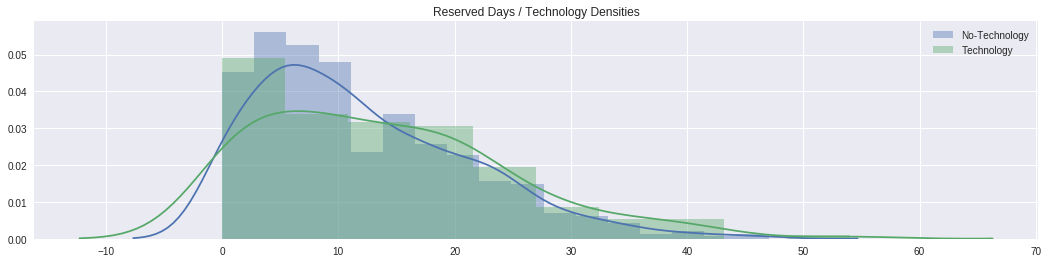

In [27]:
plt.figure(figsize = (18,4))
sns.distplot(rvec[rvec.technology == 0].rdays + rvec[rvec.technology == 0].rand, label='No-Technology')
sns.distplot(rvec[rvec.technology == 1].rdays + rvec[rvec.technology == 1].rand, label = 'Technology')
plt.title('Reserved Days / Technology Densities')
plt.legend();

In [28]:
ksr = scipy.stats.ks_2samp(rvec[rvec.technology == 0].rdays + rvec[rvec.technology == 0].rand, rvec[rvec.technology == 1].rdays + rvec[rvec.technology == 1].rand)
print(ksr, '\n')
print('There is not much difference in the reserved days distributions for tech/no-tech.')

Ks_2sampResult(statistic=0.1016300496102055, pvalue=0.10172165743711314) 

There is not much difference in the reserved days distributions for tech/no-tech.


---
## Model Prep:
---

In [29]:
# Scale the smooth:
vresbm = vres.copy()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    vresbm['sactual_price'] = preprocessing.MinMaxScaler().fit_transform(vresbm.actual_price.values.reshape(-1,1))
    vresbm['sprice_delta'] = preprocessing.MinMaxScaler((-1,1)).fit_transform(vresbm.price_delta.values.reshape(-1,1))
    vresbm['snum_images'] = preprocessing.MinMaxScaler().fit_transform(vresbm.num_images.values.reshape(-1,1))
    vresbm['sdesc'] = preprocessing.MinMaxScaler().fit_transform(vresbm.description.values.reshape(-1,1))
#vresbm = vresbm.join(pd.get_dummies(vresbm.num_images, prefix = 'img').iloc[:,:-1])
vresbm.drop(['vehicle_id', 'actual_price', 'price_delta', 'num_images', 'description', 'reservation_type','rand'], axis = 1, inplace = True)
vresbm.head(2)

,reserved,technology,street_parked,sactual_price,sprice_delta,snum_images,sdesc
rvid,,,,,,,
1,1,1,0,0.247671,-0.499413,1.0,0.024096
2,1,0,0,0.479531,0.261159,1.0,0.895582


In [30]:
# Scale the smooth:
rvecm = rvec.copy()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rvecm['sactual_price'] = preprocessing.MinMaxScaler().fit_transform(rvecm.actual_price.values.reshape(-1,1))
    rvecm['sprice_delta'] = preprocessing.MinMaxScaler((-1,1)).fit_transform(rvecm.price_delta.values.reshape(-1,1))
    rvecm['snum_images'] = preprocessing.MinMaxScaler().fit_transform(rvecm.num_images.values.reshape(-1,1))
    rvecm['sdesc'] = preprocessing.MinMaxScaler().fit_transform(rvecm.description.values.reshape(-1,1))
rvecm.drop(['actual_price', 'price_delta', 'num_images', 'description','rand'], axis = 1, inplace = True)
rvecm.head(1)

,rdays,technology,street_parked,sactual_price,sprice_delta,snum_images,sdesc
vehicle_id,,,,,,,
1,1,1,0,0.247671,-0.499413,1.0,0.024096


## Logistic Regression on Reserved/Non-reserved:
---

In [31]:
X, y = (vresbm.iloc[:, 1:], vresbm.reserved)

In [32]:
# Scikit Learn (with slightly weird intercept regularization):
binlog = linear_model.LogisticRegression(C = 10**9)
binlog.fit(X, y)
print(binlog.score(X, y))
pd.DataFrame([*zip(X.columns, np.transpose(binlog.coef_))]).sort_values(1, ascending = False)

0.986233565352


,0,1
2,sactual_price,[2.58296152484]
4,snum_images,[1.85761358538]
5,sdesc,[0.22337863164]
0,technology,[0.0111944425455]
1,street_parked,[-0.292175719093]
3,sprice_delta,[-2.34960406607]


In [33]:
# Statsmodels:
smbl2 = sm.Logit(y, X)
smbl2 = smbl2.fit()
print(smbl2.aic, smbl2.bic)
smbl2.params.sort_values(ascending = False)

Optimization terminated successfully.
         Current function value: 0.069193
         Iterations 9
906.669713917 947.314663664


sactual_price    6.267094
snum_images      2.199294
sdesc            0.483239
technology       0.417893
street_parked   -0.104207
sprice_delta    -4.051308
dtype: float64

#### The classifiers are great with almost no negative samples.

### Logistic Cross Validation: 
#### is kinda pointless here due to the lack of negative samples:
---

In [34]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 0)
binlog2 = linear_model.LogisticRegression(C = 10**9)
binlog2.fit(X_train, y_train)

LogisticRegression(C=1000000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [35]:
predicted = binlog2.predict(X_test)
probs = binlog2.predict_proba(X_test)

In [36]:
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

0.986078886311
0.806710239651
[[   0   18]
 [   0 1275]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        18
          1       0.99      1.00      0.99      1275

avg / total       0.97      0.99      0.98      1293



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
# again with 30-fold cross-validation:
scores = model_selection.cross_val_score(linear_model.LogisticRegression(C = 10**9), X, y, scoring = 'accuracy', cv = 30)
print(scores)
print(scores.mean()) # lies

[ 0.98611111  0.98611111  0.98611111  0.98611111  0.98611111  0.98611111
  0.98611111  0.98611111  0.98611111  0.98611111  0.98611111  0.98611111
  0.98611111  0.98611111  0.98611111  0.98611111  0.98604651  0.98604651
  0.98604651  0.98604651  0.98604651  0.98604651  0.98604651  0.98604651
  0.98604651  0.98604651  0.98604651  0.98604651  0.98604651  0.99065421]
0.986234554485


---
## Regressions on Rental Days:
---

In [38]:
X2, y2 = (rvecm.iloc[:, 1:], rvecm.rdays)

### OLS:
---

In [39]:
smols = sm.OLS(y2, X2)
smolsr = smols.fit()
print(smolsr.rsquared)
pd.DataFrame(smolsr.params.sort_values(ascending = False)).style.background_gradient(cmap = 'GnBu')

0.692098634631


,0
sactual_price,16.7708
snum_images,6.28897
technology,0.501343
sdesc,0.136936
street_parked,-0.232769
sprice_delta,-15.3052


### Bayesian Regression:
---

In [40]:
# Bayesian Sampling For Linear Parameters
num_samples = 2*10**4
glm = pm.Model()
with glm:
    model_str = 'rdays ~ technology + sactual_price + sprice_delta + snum_images + street_parked + sdesc'
    pm.glm.glm(model_str, rvecm)
    step = pm.step_methods.Metropolis()
    trace = pm.sample(num_samples, step, progressbar = True)
# Results...
throwaway = int(0.5 * num_samples)
summary = pm.df_summary(trace[throwaway:])

100%|██████████| 20000/20000 [00:24<00:00, 828.02it/s]


In [41]:
pd.DataFrame(summary['mean'].sort_values(ascending = False)).style.background_gradient(cmap = 'GnBu')

,mean
sactual_price,11.9666
sd,8.69577
snum_images,5.67722
Intercept,2.94877
technology,-0.123842
sdesc,-0.188721
street_parked,-0.435621
sprice_delta,-13.3054


In [42]:
pd.DataFrame(summary['sd'].sort_values(ascending = False)).style.background_gradient(cmap = 'GnBu')

,sd
sactual_price,2.68472
Intercept,1.45102
sprice_delta,1.34891
sdesc,0.911654
technology,0.822199
snum_images,0.815869
street_parked,0.54055
sd,0.200411


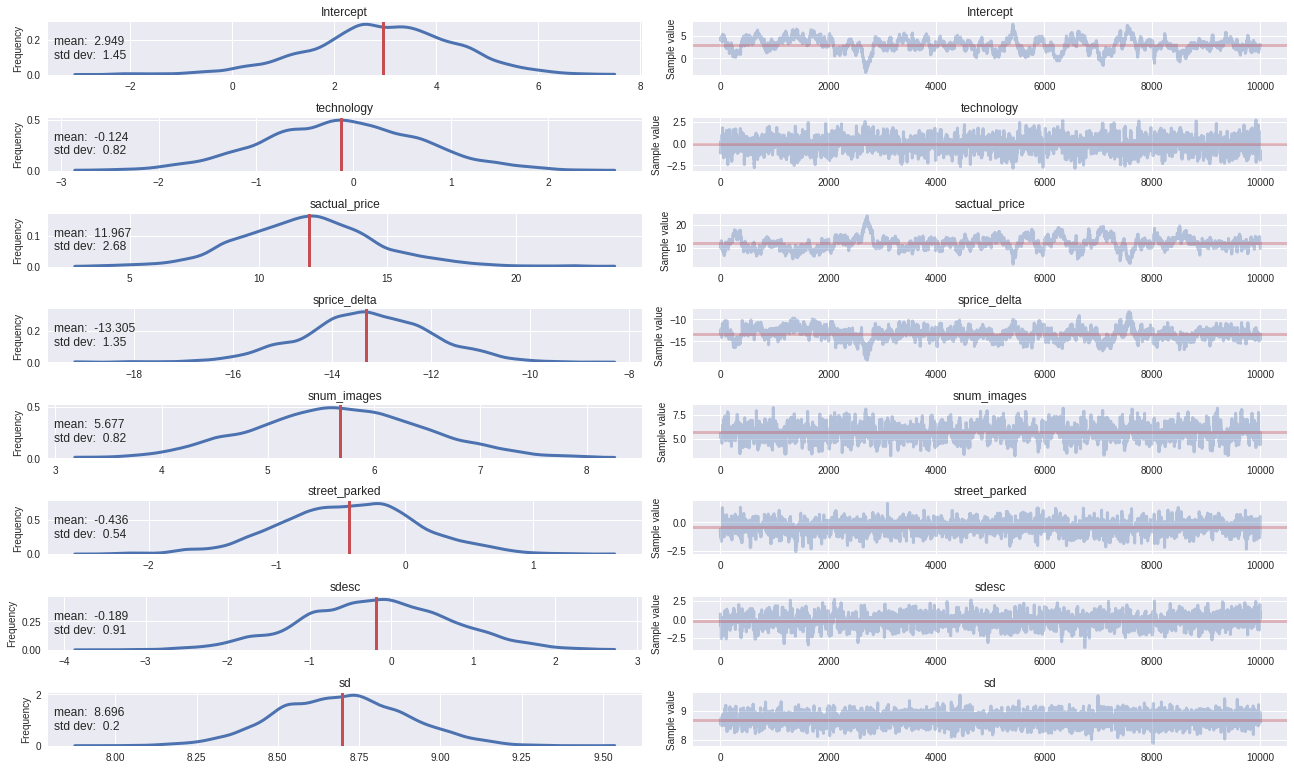

In [43]:
with glm:
    mean_dict = {k: v['mean'] for k, v in summary.iterrows()}
    err_dict = {k: v['sd'] for k, v in summary.iterrows()}
    axes = pm.traceplot(trace[throwaway:], figsize = (18, 1.2*len(trace.varnames)), lines = mean_dict, grid = True);
    for ax2 in axes:
        for chart_num, ax in enumerate(ax2):
            varkey = ax.title.get_text()
            if chart_num == 0:
                cmu = round(mean_dict[varkey], 3)
                csd = round(err_dict[varkey], 2)
                ax.text(0.01, 0.5, 'mean:  %s\nstd dev:  %s' % (cmu, csd), fontsize = 12, horizontalalignment = 'left', verticalalignment = 'center', transform = ax.transAxes)
            ax.title.set_fontsize(12)
            for item in ax.get_lines():
                item.set_linewidth(3)
            for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_yticklabels()):
                item.set_fontsize(10)
            for item in ax.get_xticklabels():
                item.set_fontsize(10)

### SVR based feature selection:
---

In [44]:
for idx in range(1, 7):
    rfe = feature_selection.RFE(svm.SVR(kernel = 'linear'), idx)
    rfe_fit = rfe.fit(X2, y2)
    print('Features[%s]: ' % idx, sorted(zip(rfe_fit.ranking_, X2.columns.tolist())))

Features[1]:  [(1, 'snum_images'), (2, 'sprice_delta'), (3, 'sactual_price'), (4, 'street_parked'), (5, 'technology'), (6, 'sdesc')]
Features[2]:  [(1, 'snum_images'), (1, 'sprice_delta'), (2, 'sactual_price'), (3, 'street_parked'), (4, 'technology'), (5, 'sdesc')]
Features[3]:  [(1, 'sactual_price'), (1, 'snum_images'), (1, 'sprice_delta'), (2, 'street_parked'), (3, 'technology'), (4, 'sdesc')]
Features[4]:  [(1, 'sactual_price'), (1, 'snum_images'), (1, 'sprice_delta'), (1, 'street_parked'), (2, 'technology'), (3, 'sdesc')]
Features[5]:  [(1, 'sactual_price'), (1, 'snum_images'), (1, 'sprice_delta'), (1, 'street_parked'), (1, 'technology'), (2, 'sdesc')]
Features[6]:  [(1, 'sactual_price'), (1, 'sdesc'), (1, 'snum_images'), (1, 'sprice_delta'), (1, 'street_parked'), (1, 'technology')]


### F-Statistic based feature selection:
---

In [45]:
fstats, fpvals = feature_selection.f_regression(X2, y2)
print('F-Stat\t\t\t P-Val\t\t\t Feature')
[*reversed(sorted(zip(fstats, fpvals, rvec.columns.tolist()[1:])))]

F-Stat			 P-Val			 Feature


[(130.17479795325056, 1.9872024408264561e-28, 'num_images'),
 (53.390959812478251, 5.5902218855446214e-13, 'price_delta'),
 (50.471100126310517, 2.2976666731144749e-12, 'street_parked'),
 (4.5175411409393007, 0.033794106293355587, 'technology'),
 (0.43881375982503729, 0.50784850166210327, 'actual_price'),
 (0.093764604795430168, 0.75950857495829349, 'description')]

### Mutual Information based Feature Selection:
---

In [46]:
mir = feature_selection.mutual_info_regression(X2, y2)
[*reversed(sorted(zip(mir, rvec.columns.tolist()[1:])))]

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


[(0.10252605755357136, 'num_images'),
 (0.050844179234824427, 'description'),
 (0.018441376828077338, 'street_parked'),
 (0.0, 'technology'),
 (0.0, 'price_delta'),
 (0.0, 'actual_price')]

In [47]:
mic = feature_selection.mutual_info_classif(X, y)
[*reversed(sorted(zip(mic, vresbm.columns.tolist()[1:])))]

[(0.013337722162997334, 'sprice_delta'),
 (0.0096227025542831024, 'sactual_price'),
 (0.0028883322757442542, 'sdesc'),
 (0.0023081875973798294, 'snum_images'),
 (0.0, 'technology'),
 (0.0, 'street_parked')]

### Decision Tree Regression:
---

0.2729775723


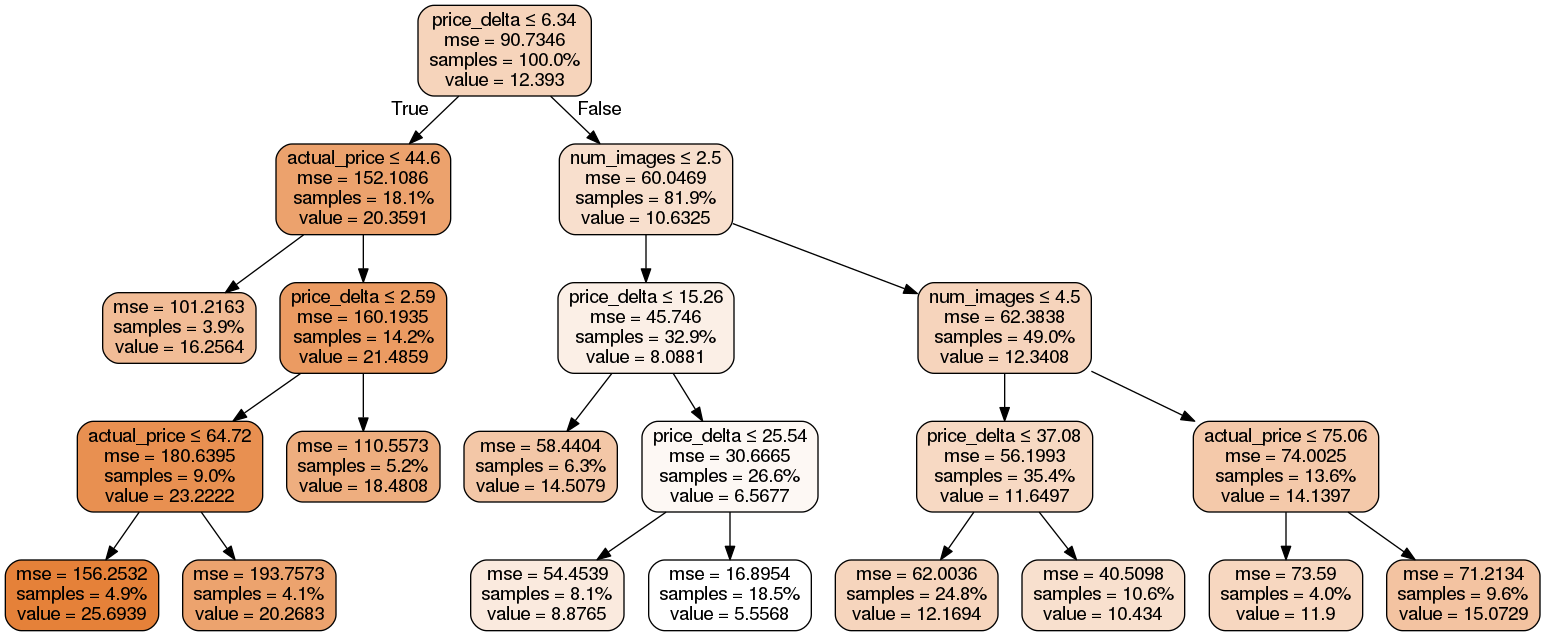

In [48]:
dtree = tree.DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 34)
tree_fit = dtree.fit(rvec.iloc[:, 1:-1], rvec.rdays)
print(dtree.score(rvec.iloc[:, 1:-1], rvec.rdays))
tree_xvars = list(rvec.iloc[:, 1:-1].columns.values)
tree_dot = tree.export_graphviz(tree_fit, out_file = None, filled = True, rounded = True, special_characters = True, proportion = True, feature_names = tree_xvars)
tree_graph = pydotplus.graph_from_dot_data(tree_dot)
Image(tree_graph.create_png())